<a href="https://colab.research.google.com/github/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow/blob/main/cristie_mod6_proj_final_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# **Ciência de Dados: Fundamentos de Machine Learning**
---
---

## **Pós-graduação em Ciência de Dados (2025/2026)**

**Escola Superior de Tecnologia da Universidade Estadual do Amazonas - EST/UEA**
    
**Disciplina:** Fundamentos de Machine Learning

**Prof. Me.:** Mario Bessa

_**Repositório do Projeto Acadêmico no Github:** [e-SUS_Sinan_Mpox_ML-Workflow](https://github.com/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow)_

_**Alunos:**_

- _A. Cristiane R. Lima (Cristie)_
- _José Henrique Santos Cavalcante (Henrique)_

_**Data:** 30 de agosto de 2025_


## **Projeto Final**
Este projeto está dividido em 2 notebooks para contemplar o fluxo completo de pré-modelagem e modelagem para o dataset [e-SUS Sinan/Mpox](https://opendatasus.saude.gov.br/ne/dataset/mpox), seguindo uma estrutura padronizada, do seguinte modo:

- cristie_mod6_proj_final_parte_1.ipynb: Aquisição, Análise Descritiva e Exploratória de Dados (EDA), Pré-processamento (Correção )

Foi desenvolvido a partir do notebook-base apresentado e explicado ao longo as aulas teórico-práticas em laboratório do Professor.

---

💡 **Nota técnica:** O link para o Dicionário de Dados está disponível na seção de *Análise Descritiva*. Recomenda-se mantê-lo aberto para facilitar a interpretação das variáveis.

⚠️ **Observação:** Linhas com o comentário `#debug#` indicam trechos opcionais para testes e inspeções pontuais — como a geração de arquivos `.csv` temporários para verificar o estado do DataFrame após imputações.

📚 **Referência:**  
KELLEHER, John D.; MAC NAMEE, Brian; D’ARCY, Aoife. *Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies*. 2. ed. Cambridge, MA: MIT Press, 2020.


---
### **Contextualização do Projeto**

A Mpox (Monkeypox) é uma doença infecciosa emergente que ganhou atenção internacional devido ao seu potencial de disseminação e impacto na saúde pública. No Brasil, o sistema e-SUS Sinan tem sido fundamental para o registro e monitoramento dos casos, permitindo a construção de bases de dados estruturadas para análise epidemiológica.

Este projeto tem como objetivo aplicar técnicas de aprendizado de máquina para explorar, tratar e modelar os dados disponíveis, com foco na geração de insights preditivos que possam apoiar estratégias de vigilância e resposta. A abordagem adotada contempla desde o pré-processamento e imputação de dados até a construção de modelos supervisionados, seguindo diretrizes metodológicas discutidas em ambiente acadêmico.

---

**Instruções:**

- Realizar os processamentos abaixo:

  - No notebook `cristie_mod6_proj_final_parte_1.ipynb`:
    -  Atividade 1: Limpar dados incorretos
    -  Atividade 2: Imputação de valores faltantes
    -  Atividade 3: Codificação de variáveis categóricas (OrdinalEncoder e OneHotEncoder)
    -  Atividade 4: Escalonamento de variáveis numéricas (StandardScaler e MinMaxScaler)
  - No notebook `cristie_mod6_proj_final_parte_2.ipynb`:
    -  Atividade 5: Balanceamento dos dados (Tomek e Smote)
    -  Atividade 6: Treinamento dos modelos de Machine Learning
    -  Atividade 7: Usar o modelo treinado

---
## **Atividade 6: Treinamento dos modelos de Machine Learning**
- Comparar modelos: testar diferentes classificadores
    - Classificação binária
    - Modelos: Naive Bayes, Árvore de Decisão, Random Forest, Aprendizagem baseada em instâncias - kNN, Regressão logística, SVM, Redes Neurais Artificiais
- Medir desempenho com métricas adequadas e evitar overfitting
- Investigar como técnicas de imputação e codificação impactam os resultados
- Escolher e ajustar modelos (gridsearch/validação cruzada)
---

Configuração Inicial:

- 📦 Importação das bibliotecas
- 🔄 Carregar dados já pré-processados (Tomek + SMOTE aplicados)
- ✂️ Divisão treino/teste


In [ ]:
# ================================
# 📦 Importação das bibliotecas
# ================================
# pandas/numpy → manipulação de dados
import pandas as pd
import numpy as np

# sklearn → modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

# visualização
import matplotlib.pyplot as plt
import seaborn as sns

# salvar/carregar modelos
import joblib

# ================================
# 🔄 Carregar dados já pré-processados (Tomek + SMOTE aplicados)
# ================================
X = joblib.load("/content/X_mpox_2022_target_hosp_tomek_smote.pkl")
y = joblib.load("/content/y_mpox_2022_target_hosp_tomek_smote.pkl")

# ================================
# ✂️ Divisão treino/teste
# - Mantemos proporção de classes (stratify=y)
# - 80% treino, 20% teste
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)
print("Distribuição classes (treino):\n", y_train.value_counts(normalize=True))


Tamanho treino: (16958, 1388)  | Tamanho teste: (4240, 1388)
Distribuição classes (treino):
 target_hosp
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Função auxiliar de avaliação

In [ ]:
def avaliar_modelo(modelo, X_train, y_train, X_test, y_test, nome_modelo):
    """
    Treina e avalia um modelo de classificação.

    Passos:
    1. Treina com dados de treino.
    2. Prediz nos dados de teste.
    3. Calcula métricas (Accuracy, Precision, Recall, F1, AUC).
    4. Exibe relatório, matriz de confusão e curva ROC.

    Retorna: dicionário com métricas principais (para comparação entre modelos).
    """
    # Treinamento do modelo
    modelo.fit(X_train, y_train)

    # Predição
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None

    # Cálculo das métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Exibição de resultados
    print(f"\n📊 Resultados - {nome_modelo}")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
    print(f"AUC: {auc:.3f}")

    # Curva ROC (quando disponível)
    if y_proba is not None:
        RocCurveDisplay.from_estimator(modelo, X_test, y_test)
        plt.title(f"Curva ROC - {nome_modelo}")
        plt.show()

    # Retorno para comparação final
    return {"Modelo": nome_modelo, "Accuracy": acc, "Precision": prec,
            "Recall": rec, "F1": f1, "AUC": auc}

# Lista para armazenar os resultados de todos os modelos
resultados = []


In [ ]:
# Visualização rápida
print(X.head(1))
print(y.value_counts())

#type(X_loaded)
#type(y_loaded)


   NU_IDADE_N   SIFILIS  CONTAG_CD4  SINTOMA_missing  OUTRO_DES_missing  \
0    0.134523 -0.289047    0.261253        -0.126876           0.293487   

   PROFIS_SAUDE_missing  LOCAL_CONT_missing  TRANSM_missing  \
0              -2.68985            -2.68985       -0.115191   

   CONTAT_ANIMAL_missing  CARACT_GENOMICA_missing  ...  SG_UF_NOT_PR  \
0              -0.115191                -0.115191  ...     -0.219054   

   SG_UF_NOT_RJ  SG_UF_NOT_RN  SG_UF_NOT_RO  SG_UF_NOT_RR  SG_UF_NOT_RS  \
0     -0.382854     -0.113548     -0.027077     -0.023447     -0.178993   

   SG_UF_NOT_SC  SG_UF_NOT_SE  SG_UF_NOT_SP  SG_UF_NOT_TO  
0     -0.208514      -0.08316     -0.796853     -0.040633  

[1 rows x 1388 columns]
target_hosp
0    10599
1    10599
Name: count, dtype: int64


🔹 1. Naive Bayes

📘 Teoria: assume independência condicional entre atributos (Kelleher, cap. 8).
Bom para baseline rápido, mesmo que a suposição seja simplista.


📊 Resultados - Naive Bayes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2120
           1       1.00      1.00      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2119    1]
 [   0 2120]]
AUC: 1.000


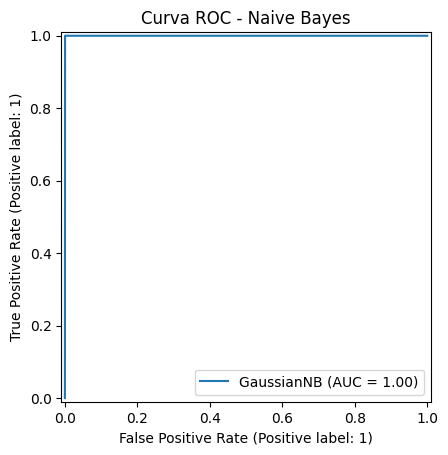

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
resultados.append(avaliar_modelo(nb, X_train, y_train, X_test, y_test, "Naive Bayes"))


🔹 2. Regressão Logística

📘 Teoria: modelo linear que estima probabilidades. Muito usado em saúde pela interpretabilidade (odds ratio).


📊 Resultados - Regressão Logística
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2120
           1       0.98      1.00      0.99      2120

    accuracy                           0.99      4240
   macro avg       0.99      0.99      0.99      4240
weighted avg       0.99      0.99      0.99      4240

Matriz de Confusão:
 [[2080   40]
 [   0 2120]]
AUC: 1.000


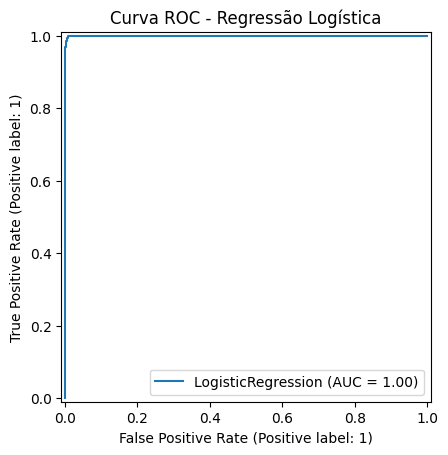

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
resultados.append(avaliar_modelo(log_reg, X_train, y_train, X_test, y_test, "Regressão Logística"))


🔹 3. Árvore de Decisão

📘 Teoria: gera regras hierárquicas “if-then”. Boa interpretabilidade, mas risco de overfitting se não podada.


📊 Resultados - Árvore de Decisão
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2120
           1       1.00      1.00      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2119    1]
 [   7 2113]]
AUC: 0.998


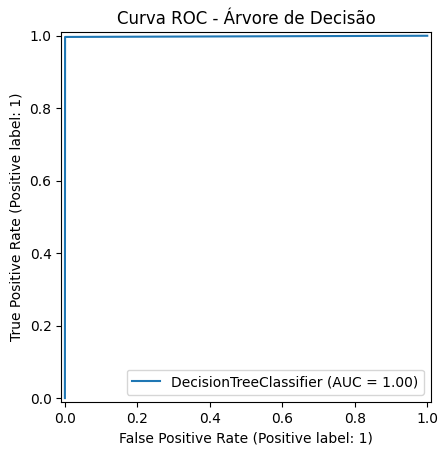

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
resultados.append(avaliar_modelo(tree, X_train, y_train, X_test, y_test, "Árvore de Decisão"))


🔹 4. kNN

📘 Teoria: classifica pelo “voto” dos vizinhos mais próximos. Simples, mas sensível a escala e dados ruidosos


📊 Resultados - kNN
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2120
           1       0.97      1.00      0.99      2120

    accuracy                           0.99      4240
   macro avg       0.99      0.99      0.99      4240
weighted avg       0.99      0.99      0.99      4240

Matriz de Confusão:
 [[2064   56]
 [   0 2120]]
AUC: 0.996


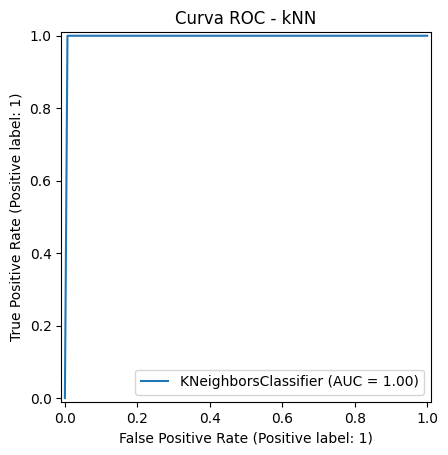

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # k=5 é default, pode ser ajustado
resultados.append(avaliar_modelo(knn, X_train, y_train, X_test, y_test, "kNN"))


🔹 5. Random Forest

📘 Teoria: conjunto de várias árvores de decisão com amostragem aleatória. Reduz overfitting, aumenta robustez


📊 Resultados - Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2120
           1       1.00      0.99      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2114    6]
 [  11 2109]]
AUC: 1.000


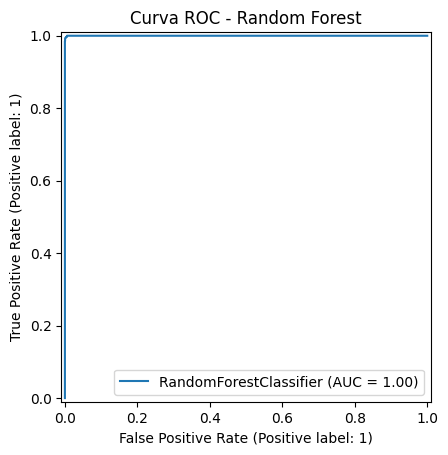

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
resultados.append(avaliar_modelo(rf, X_train, y_train, X_test, y_test, "Random Forest"))


🔹 6. SVM

📘 Teoria: encontra hiperplano ótimo para separar classes. Potente em dados complexos, mas exige tuning (kernel, C, γ).


📊 Resultados - SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2120
           1       1.00      1.00      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2116    4]
 [   0 2120]]
AUC: 1.000


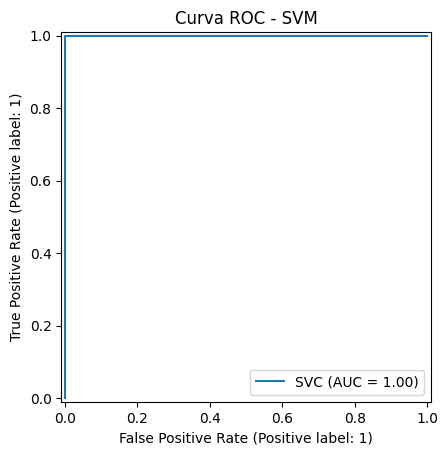

In [ ]:
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)  # probability=True para permitir ROC
resultados.append(avaliar_modelo(svm, X_train, y_train, X_test, y_test, "SVM"))


🔹 7. Rede Neural (MLP)

📘 Teoria: modelo inspirado no cérebro humano, com múltiplas camadas ocultas. Captura padrões complexos, mas menos interpretável.


📊 Resultados - Rede Neural (MLP)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2120
           1       0.99      1.00      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2108   12]
 [   0 2120]]
AUC: 1.000


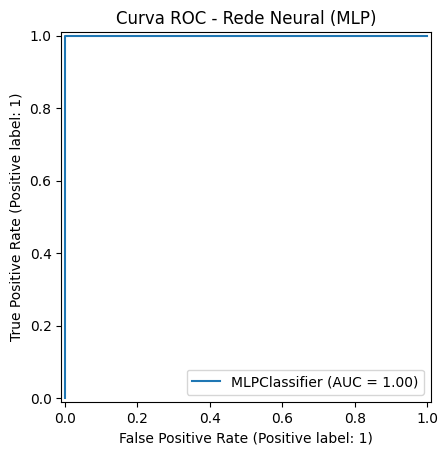

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
resultados.append(avaliar_modelo(mlp, X_train, y_train, X_test, y_test, "Rede Neural (MLP)"))


🔹 Comparação final entre modelos

In [ ]:
# Criar DataFrame comparativo
df_resultados = pd.DataFrame(resultados)

print("\n📊 Comparação de Métricas entre Modelos")
display(df_resultados.sort_values(by="F1", ascending=False))



📊 Comparação de Métricas entre Modelos


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Naive Bayes,0.999764,0.999529,1.000000,0.999764,0.999764
5,SVM,0.999057,0.998117,1.000000,0.999057,1.000000
2,Árvore de Decisão,0.998113,0.999527,0.996698,0.998111,0.998113
6,Rede Neural (MLP),0.997170,0.994371,1.000000,0.997178,1.000000
4,Random Forest,0.995991,0.997163,0.994811,0.995986,0.999969
1,Regressão Logística,0.990566,0.981481,1.000000,0.990654,0.999844
3,kNN,0.986792,0.974265,1.000000,0.986965,0.996462


---
## **Atividade 7: Usar o modelo treinado**
- Salvar os transformadores
- Salvar o modelo
- Fazer predição usando dados novos
---


Naive Bayes

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = nb

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))



🔮 Predições em novos dados simulados:
Probabilidades: [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Classe prevista: [1 0 0 0 1]


SVM

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = nb

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))



🔮 Predições em novos dados simulados:
Probabilidades: [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Classe prevista: [1 0 0 0 1]


Árvore de Decisão

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = tree

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))



🔮 Predições em novos dados simulados:
Probabilidades: [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Classe prevista: [1 0 0 0 1]


Rede Neural (MLP)

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = mlp

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_mlp.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_mlp.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))



🔮 Predições em novos dados simulados:
Probabilidades: [[8.24430331e-07 9.99999176e-01]
 [9.99269372e-01 7.30627899e-04]
 [9.99983475e-01 1.65247660e-05]
 [9.99999910e-01 8.98081783e-08]
 [8.51169840e-08 9.99999915e-01]]
Classe prevista: [1 0 0 0 1]


Random Forest

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = rf

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_rf.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_rf.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))



🔮 Predições em novos dados simulados:
Probabilidades: [[0.075 0.925]
 [0.91  0.09 ]
 [0.965 0.035]
 [1.    0.   ]
 [0.    1.   ]]
Classe prevista: [1 0 0 0 1]


Regressão Logística

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = log_reg

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_log_reg.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_log_reg.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))



🔮 Predições em novos dados simulados:
Probabilidades: [[3.32600837e-06 9.99996674e-01]
 [9.98462664e-01 1.53733641e-03]
 [9.99567555e-01 4.32445114e-04]
 [9.99985824e-01 1.41757249e-05]
 [4.71354035e-06 9.99995286e-01]]
Classe prevista: [1 0 0 0 1]


kNN

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = knn

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_knn.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_knn.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))



🔮 Predições em novos dados simulados:
Probabilidades: [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Classe prevista: [1 0 0 0 1]


In [ ]:
import os

# ================================
# 📂 Criar pasta para salvar os modelos
# ================================
os.makedirs("modelos_salvos", exist_ok=True)

# ================================
# 🔄 Loop para salvar e recarregar todos os modelos
# ================================
modelos_treinados = {
    "NaiveBayes": nb,
    "RegressaoLogistica": log_reg,
    "ArvoreDecisao": tree,
    "kNN": knn,
    "RandomForest": rf,
    "SVM": svm,
    "RedeNeuralMLP": mlp
}

for nome, modelo in modelos_treinados.items():
    print(f"\n=== 🔄 Testando reuso do modelo: {nome} ===")

    # 1. Salvar modelo em arquivo PKL
    caminho = f"modelos_salvos/{nome}.pkl"
    joblib.dump(modelo, caminho)
    print(f"✅ Modelo salvo em: {caminho}")

    # 2. Recarregar modelo salvo
    modelo_carregado = joblib.load(caminho)

    # 3. Testar predição em uma pequena amostra (5 registros de teste)
    amostra = X_test.iloc[:5]
    pred = modelo_carregado.predict(amostra)
    proba = modelo_carregado.predict_proba(amostra)[:,1] if hasattr(modelo_carregado, "predict_proba") else "N/A"

    print("🔮 Predições:", pred)
    print("📊 Probabilidades:", proba)



=== 🔄 Testando reuso do modelo: NaiveBayes ===
✅ Modelo salvo em: modelos_salvos/NaiveBayes.pkl
🔮 Predições: [1 0 0 0 1]
📊 Probabilidades: [1. 0. 0. 0. 1.]

=== 🔄 Testando reuso do modelo: RegressaoLogistica ===
✅ Modelo salvo em: modelos_salvos/RegressaoLogistica.pkl
🔮 Predições: [1 0 0 0 1]
📊 Probabilidades: [9.99996674e-01 1.53733641e-03 4.32445114e-04 1.41757249e-05
 9.99995286e-01]

=== 🔄 Testando reuso do modelo: ArvoreDecisao ===
✅ Modelo salvo em: modelos_salvos/ArvoreDecisao.pkl
🔮 Predições: [1 0 0 0 1]
📊 Probabilidades: [1. 0. 0. 0. 1.]

=== 🔄 Testando reuso do modelo: kNN ===
✅ Modelo salvo em: modelos_salvos/kNN.pkl
🔮 Predições: [1 0 0 0 1]
📊 Probabilidades: [1. 0. 0. 0. 1.]

=== 🔄 Testando reuso do modelo: RandomForest ===
✅ Modelo salvo em: modelos_salvos/RandomForest.pkl
🔮 Predições: [1 0 0 0 1]
📊 Probabilidades: [0.925 0.09  0.035 0.    1.   ]

=== 🔄 Testando reuso do modelo: SVM ===
✅ Modelo salvo em: modelos_salvos/SVM.pkl
🔮 Predições: [1 0 0 0 1]
📊 Probabilidades: [